In [1]:
import torch

"""Select device (GPU)"""
device = 'cuda' if torch.cuda.is_available() else 'cpu'


print('Selected device:', device)

Selected device: cuda


In [2]:
import pandas as pd

"""Load Tokens from CSV"""
df = pd.read_csv(
    '../data-sets/Zinparen in Engels-Nederlands - 2024-10-21.csv',
    names=['ENG_TOKENS', 'NLD_TOKENS'])


df

,ENG_TOKENS,NLD_TOKENS
0,ENG_TOKENS,NLD_TOKENS
1,<SOS> Let 's try something . <EOS>,<SOS> Laten we iets proberen ! <EOS>
2,<SOS> Let 's try something . <EOS>,<SOS> Laat ons iets proberen . <EOS>
3,<SOS> I have to go to sleep . <EOS>,<SOS> Ik moet gaan slapen . <EOS>
4,<SOS> Today is June 18th and it is Muiriel 's ...,<SOS> Vandaag is het 18 juni en het is de verj...
...,...,...
153805,<SOS> Cotton candy is usually sold and made at...,<SOS> Suikerspinnen worden gewoonlijk verkocht...
153806,<SOS> At the moment I am looking for a job . <...,<SOS> Op het moment ben ik op zoek naar werk ....
153807,<SOS> The unthinkable happened . <EOS>,<SOS> Het ondenkbare is gebeurd . <EOS>
153808,<SOS> Let 's wait until she rings . <EOS>,<SOS> Laten we wachten tot ze belt ! <EOS>


In [3]:
TRAIN_SPLIT = 0.9
MAX_SIZE = 20
FORBIDDEN_CHARS = ['€', '$']

"""Filtering"""
def filter(row):
	eng_tokens = row['ENG_TOKENS'].split()
	nld_tokens = row['NLD_TOKENS'].split()

	if (len(eng_tokens) > MAX_SIZE):
		return False

	if (len(nld_tokens) > MAX_SIZE):
		return False

	if any(char in eng_tokens or char in nld_tokens for char in FORBIDDEN_CHARS):
		return False

	return True

df = df[df.apply(filter, axis=1)]

"""Splitting Training and Validation Data"""
df = df.sample(frac=1).reset_index(drop=True)
split = int(TRAIN_SPLIT * len(df))

train_data = df.iloc[:split, :]
test_data  = df.iloc[split:, :]
test_data.reset_index(drop=True, inplace=True)


print('Total rows from file:', len(df))
print('Total rows of train data:', len(train_data))
train_data

Total rows from file: 152194
Total rows of train data: 136974


,ENG_TOKENS,NLD_TOKENS
0,<SOS> I like reading . <EOS>,<SOS> Ik lees graag . <EOS>
1,<SOS> What 's that ? <EOS>,<SOS> Wat is dat ? <EOS>
2,<SOS> I 'm speaking Spanish to my cat . <EOS>,<SOS> Tegen mijn kat spreek ik Spaans . <EOS>
3,<SOS> We 'll help . <EOS>,<SOS> Wij zullen helpen . <EOS>
4,<SOS> I let her sleep in . <EOS>,<SOS> Ik liet haar uitslapen . <EOS>
...,...,...
136969,<SOS> There 's no way I 'm doing that . <EOS>,<SOS> Dat ga ik echt niet doen . <EOS>
136970,<SOS> Tom is OK . <EOS>,<SOS> Tom is in orde . <EOS>
136971,<SOS> There was nothing I could do to stop him...,<SOS> Er was niets dat ik kon doen om hem te s...
136972,<SOS> It is still night . <EOS>,<SOS> Het is nog nacht . <EOS>


In [4]:
from utils.Vocabulary import Vocabulary

"""Create a vocabulary to lookup indices"""
eng_vocab = Vocabulary('ENG')
nld_vocab = Vocabulary('NLD')

for sentence in train_data['ENG_TOKENS']:
    eng_vocab.add_sentence(sentence)

for sentence in train_data['NLD_TOKENS']:
    nld_vocab.add_sentence(sentence)

eng_vocab.trim()
nld_vocab.trim()


print('English vocab size:', len(eng_vocab))
print('Dutch vocab size:', len(nld_vocab))

English vocab size: 7909
Dutch vocab size: 9122


In [5]:
pad_index = 0 # Same for both ENG and NLD

"""Vectorize tokens"""
def build_dataset(subset):
	X = []
	Y = []

	for _, row in subset.iterrows():
		eng_ixs = eng_vocab.lookup_indices(row['ENG_TOKENS'].split())
		eng_ixs = eng_ixs + [pad_index] * (MAX_SIZE - len(eng_ixs))
		X.append(eng_ixs)

		nld_ixs = nld_vocab.lookup_indices(row['NLD_TOKENS'].split())
		nld_ixs = nld_ixs + [pad_index] * (MAX_SIZE - len(nld_ixs))
		Y.append(nld_ixs)

	X = torch.tensor(X, dtype=torch.long)
	Y = torch.tensor(Y, dtype=torch.long)

	return X, Y


Xtr, Ytr = build_dataset(train_data)
Xte, Yte = build_dataset(test_data)


import random

print('Xtr shape:', Xtr.shape)
print()
print('Random vector:')
ix = random.randint(0, len(Xtr))
print(Xtr[ix].tolist())
print(Ytr[ix].tolist())
print()
print(eng_vocab.lookup_tokens(Xtr[ix].tolist()))
print(nld_vocab.lookup_tokens(Ytr[ix].tolist()))


Xtr shape: torch.Size([136974, 20])

Random vector:
[1, 72, 856, 331, 4, 231, 74, 81, 9, 50, 152, 10, 856, 15, 428, 7, 2, 0, 0, 0]
[1, 879, 880, 16, 366, 9, 32, 50, 144, 1502, 67, 144, 508, 7, 2, 0, 0, 0, 0, 0]

['<SOS>', 'As', 'far', 'as', 'I', 'know', ',', 'it', "'s", 'not', 'all', 'that', 'far', 'to', 'walk', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'Voor', 'zover', 'ik', 'weet', 'is', 'het', 'niet', 'te', 'ver', 'om', 'te', 'lopen', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [6]:
""" Hyperparameters: """

# Model parameters
emb_dim       = 300
hidden_size   = 400 # The same hidden size for encoder and decoder
num_layers    =   3
dropout       =   0

# Training parameters
batch_size    = 64
iterations    = 150000
learning_rate = 0.00013 # The lower the batch size, the lower the learning rate
weight_decay  = 0.00013 # Penalize complexity by couting weights into the loss function
step_size     = 150001 # Period of learning rate decay
gamma         = 1 # Multiplicative factor of learning rate decay
forced_teaching_start_ratio = 1
forced_teaching_final_ratio = 0

In [7]:
from RNN.Seq2Seq import Seq2Seq

""" Construct the model """
model = Seq2Seq(
    len(eng_vocab),
    len(nld_vocab),
    emb_dim,
    hidden_size,
    hidden_size,
    num_layers,
    dropout,
).to(device)


print("Total parameters:", sum(p.numel() for p in model.parameters()))

Total parameters: 20670022


In [8]:
# https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html

import torch.nn as nn



criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # Optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma) # Learning rate scheduler

In [9]:
"""
Functions for the training loop
"""

""" Calculate a teaching ratio, starts with a high ratio and lowers throughout training """
def forced_teaching_ratio(current_epoch, total_epochs):
    start_ratio = forced_teaching_start_ratio
    final_ratio = forced_teaching_final_ratio
    progress = current_epoch / total_epochs
    return start_ratio - (start_ratio - final_ratio) * progress

""" Calculate loss on train and test data """
def log_statistics(eval_batch_size=64):

    inputs = torch.zeros((eval_batch_size, MAX_SIZE), dtype=torch.long).to(device)
    inputs[:, 0] = 1 # <SOS> has index of 1

    model.eval()
    with torch.inference_mode():

        # Sample the models performence on a subset of training data
        ix = torch.randint(0, Xtr.shape[0], (eval_batch_size,))
        Xb, Yb = Xtr[ix].to(device), Ytr[ix].to(device)

        outputs = model(Xb, inputs)
        train_loss = criterion(outputs, Yb)


        # Sample the models performence on a subset of testing data
        ix = torch.randint(0, Xte.shape[0], (eval_batch_size,))
        Xb, Yb = Xte[ix].to(device), Yte[ix].to(device)

        outputs = model(Xb, inputs)
        test_loss = criterion(outputs, Yb)


        return train_loss.item(), test_loss.item()

In [10]:
from tqdm import trange

epoch_count       = []
train_loss_values = []
test_loss_values  = []
learning_rates    = []

for i in trange(iterations):
    model.train()
    ft_ratio = forced_teaching_ratio(i, iterations)

    ''' Sample mini-batch and send to gpu '''
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix].to(device), Ytr[ix].to(device)

    ''' Perform a single training iteration '''
    output = model(Xb, Yb, ft_ratio) # Do the forward pass
    loss = criterion(output, Yb)     # Calculate the loss
    optimizer.zero_grad()            # Reset parameters
    loss.backward()                  # Backpropagation
    optimizer.step()                 # Update parameters
    scheduler.step()                 # Step the scheduler

    ''' Report progression every so often '''
    if ((i + 1) % (iterations / 50) == 0):
        train_loss, test_loss = log_statistics(5*batch_size)

        epoch_count.append(i) # Visualize
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)
        learning_rates.append(scheduler.get_last_lr())


''' Determine model's performance based on a larger subset '''
train_loss, test_loss = log_statistics(5*batch_size)

epoch_count.append(i) # Visualize
train_loss_values.append(train_loss)
test_loss_values.append(test_loss)
learning_rates.append(scheduler.get_last_lr())


# Print final results
print()
print('Final training loss:', round(train_loss, 3))
print('Final test loss:    ', round(test_loss, 3))

100%|██████████| 150000/150000 [2:26:58<00:00, 17.01it/s] 



Final training loss: 0.813
Final test loss:     1.008


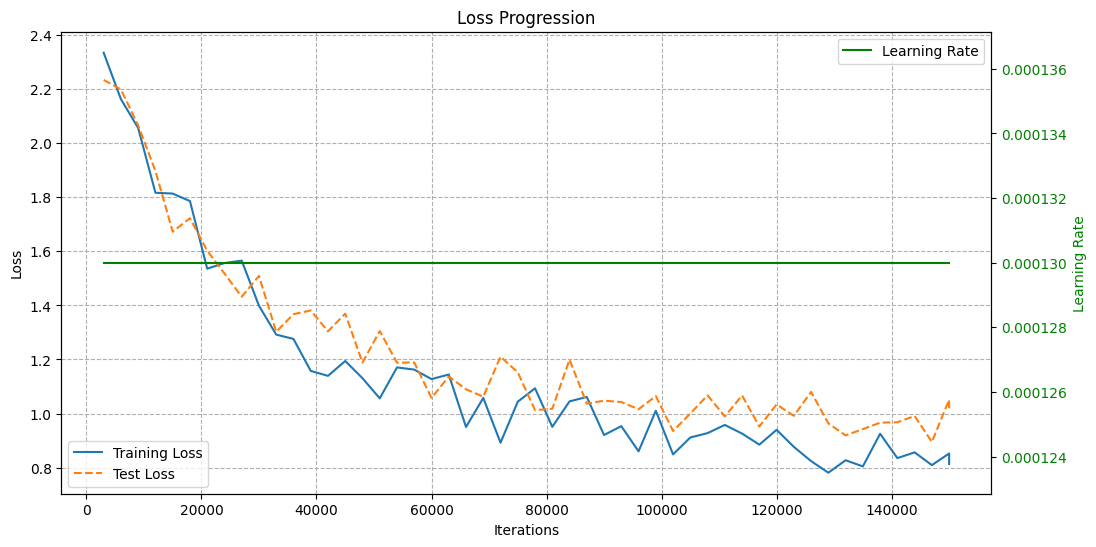

In [11]:
import matplotlib.pyplot as plt

# Create the figure and the primary y-axis
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
plt.grid(ls='--')

# Plot the loss on the primary y-axis
ax1.plot(epoch_count, train_loss_values, label='Training Loss')
ax1.plot(epoch_count, test_loss_values, label='Test Loss', linestyle='--')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Progression')

# Create the secondary y-axis for the learning rate
ax2 = ax1.twinx()
ax2.plot(epoch_count, learning_rates, label='Learning Rate', color='green')
ax2.set_ylabel('Learning Rate', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legends to each y-axis
ax1.legend(loc='lower left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [12]:
# torch.save(model.state_dict(), '../models/RNN-Attention_24-10-2024.pt')

In [13]:
# import os.path

# if os.path.isfile('../models/RNN-Attention_24-10-2024.pt'):
#     print('Found saved state dictionary!')
#     model.load_state_dict(torch.load('../models/RNN-Attention_24-10-2024.pt'))

In [14]:
import nltk
from nltk.tokenize import word_tokenize

# Download the tokenizer models from nltk
nltk.download('punkt')
nltk.download('punkt_tab')

def tokenize_sentence(sentence: str) -> list:
    """Tokenize a single sentence."""
    return ['<SOS>'] + word_tokenize(sentence) + ['<EOS>']


[nltk_data] Downloading package punkt to /home/ocmkieboom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ocmkieboom/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [15]:
import re

def translate(sentence, max_output_length=20):
	input_tokens = tokenize_sentence(sentence)
	input_indices = eng_vocab.lookup_indices(input_tokens)

	output_indices, _ = model.evaluate(input_indices, device, max_output_length)
	output_tokens = nld_vocab.lookup_tokens(output_indices)

	new_sentence = ' '.join(output_tokens).capitalize()
	new_sentence = re.sub(r'\s+([.,!?])', r'\1', new_sentence)

	return new_sentence

In [16]:
### Use model ###

print(translate('Go!'))
print(translate('It\'s not Fine.'))
print(translate('I\'m very happy today.'))
print(translate('He\'s very sad.'))
print(translate('That man is wearing a white shirt.'))
print(translate('He\'s very afraid of spiders.'))
print(translate('He\'s going home to his wife.'))
print(translate('Those guys are walking to work.'))
print(translate('I\'m not going with you today.'))
print(translate('My girlfriend will not come over tomorrow.'))
print(translate('He bought his friends a present for christmas.'))


<sos> ga! <eos>
<sos> het is niet niet niet.. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<sos> ik ben erg blij vandaag vandaag vandaag vandaag. <eos>
<sos> hij is erg verdrietig. <eos>
<sos> die man draagt een witte.. <eos>
<sos> hij is erg bang voor voor. <eos>
<sos> hij gaat naar zijn zijn zijn zijn.. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<sos> ze gaan aan het het. <eos>
<sos> ik ga niet niet je je.. <eos>
<sos> mijn vriendin zal niet niet niet... <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<sos> hij kocht zijn vrienden een voor voor voor voor. <eos>


In [17]:
import matplotlib.pyplot as plt

def evaluateAndShowAttention():

    # Sample a random sentence from the test data
    input_tokens = test_data.sample()['ENG_TOKENS'].iloc[0].split()
    input_indices = eng_vocab.lookup_indices(input_tokens)

    output_indices, attentions = model.evaluate(input_indices, device)
    output_indices = output_indices[1:] # Remove single batch dimension
    output_tokens = nld_vocab.lookup_tokens(output_indices)

    output_tokens.insert(0, "<SOS>")

    attentions = attentions.cpu().numpy()

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='plasma')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(range(len(input_tokens)))
    ax.set_yticks(range(len(output_tokens)))

    ax.set_xticklabels(input_tokens, rotation=90)
    ax.set_yticklabels(output_tokens)

    plt.show()

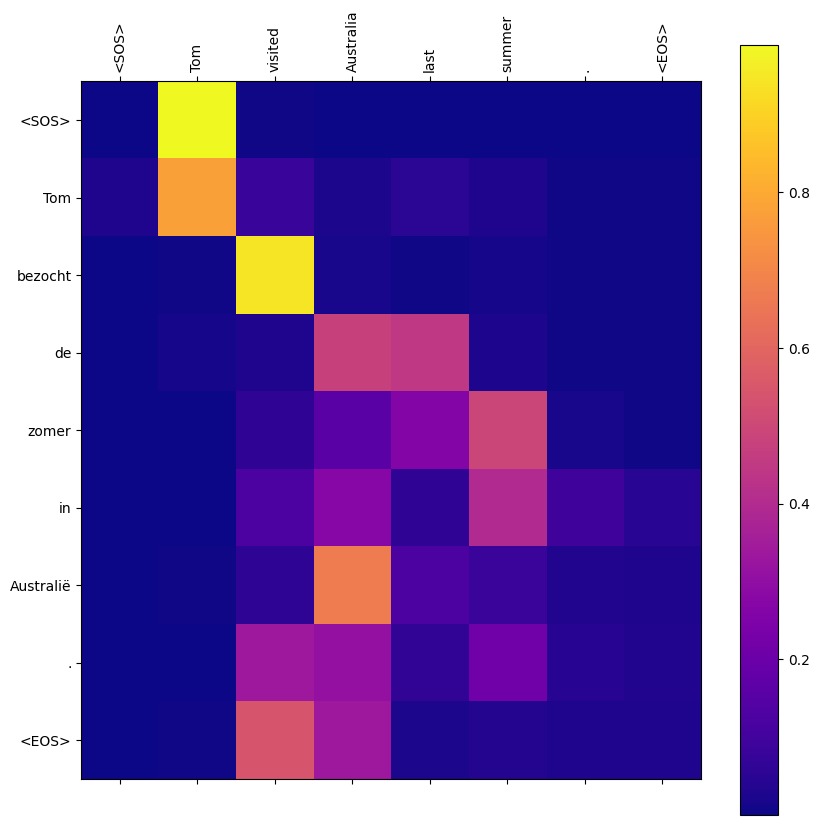

In [41]:
evaluateAndShowAttention()